In [1]:
import os 
import pandas as pd  
import spacy 
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [3]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_cnn=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_cnn
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, images):
        features = self.inception(images)
        features = self.relu(features)
        features = self.dropout(features)
        return features

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size,
                            hidden_size=hidden_size, # how many past time steps to look
                            num_layers=num_layers) # how many stacked layers
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=vocab_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)

        return outputs

In [6]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size=embed_size,
                                     train_cnn=False)
        self.decoderRNN = DecoderRNN(embed_size=embed_size,
                                     hidden_size=hidden_size,
                                     vocab_size=vocab_size,
                                     num_layers=num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [7]:
def train():
    
    global dataset
    global device
    
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="../input/flickr8k/Images/",
        annotation_file="../input/flickr8k/captions.txt",
        transform=transform,
        num_workers=8,
    )

    torch.backends.cudnn.benchmark = True
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_cnn = False
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 50

    
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_cnn

            
            
    model.train()

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
    
    torch.save(model, '/kaggle/working/image-captioning-model.pth')

In [8]:
spacy_eng = spacy.load("en")
train()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch: 1/50


Epoch: 2/50


Epoch: 3/50


Epoch: 4/50


Epoch: 5/50


Epoch: 6/50


Epoch: 7/50


Epoch: 8/50


Epoch: 9/50


Epoch: 10/50


Epoch: 11/50


Epoch: 12/50


Epoch: 13/50


Epoch: 14/50


Epoch: 15/50


Epoch: 16/50


Epoch: 17/50


Epoch: 18/50


Epoch: 19/50


Epoch: 20/50


Epoch: 21/50


Epoch: 22/50


Epoch: 23/50


Epoch: 24/50


Epoch: 25/50


Epoch: 26/50


Epoch: 27/50


Epoch: 28/50


Epoch: 29/50


Epoch: 30/50


Epoch: 31/50


Epoch: 32/50


Epoch: 33/50


Epoch: 34/50


Epoch: 35/50


Epoch: 36/50


Epoch: 37/50


Epoch: 38/50


Epoch: 39/50


Epoch: 40/50


Epoch: 41/50


Epoch: 42/50


Epoch: 43/50


Epoch: 44/50


Epoch: 45/50


Epoch: 46/50


Epoch: 47/50


Epoch: 48/50


Epoch: 49/50


Epoch: 50/50


Evaluating on following images

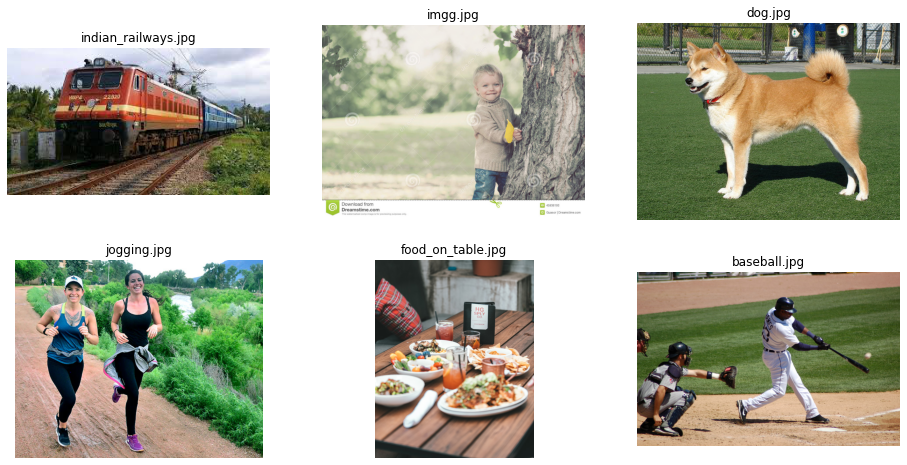

In [9]:
img_paths = os.listdir('../input/imageforcaptioning')
plt.figure(figsize=(16,8))

for idx, img_path in enumerate(img_paths):
    img = plt.imread('../input/imageforcaptioning/'+img_path)
    plt.subplot(2,3,idx+1)
    plt.imshow(np.real(img))
    plt.title(img_path)
    plt.axis('off')
plt.show()   

In [10]:
model = torch.load('/kaggle/working/image-captioning-model.pth')
model.eval()

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=T

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [12]:
def caption_all_images(image_paths):
    for img_path in image_paths:
        plt.figure(figsize=(6,4))
        full_path = '../input/imageforcaptioning/' + img_path
        img = transform(Image.open(full_path).convert("RGB")).unsqueeze(0)
        caption = ' '.join(model.caption_image(img.to('cuda'), dataset.vocab)[1:-1])
        read_img = plt.imread(full_path)
        plt.imshow(np.real(read_img))
        plt.axis("off")
        plt.title(caption)
        plt.show()

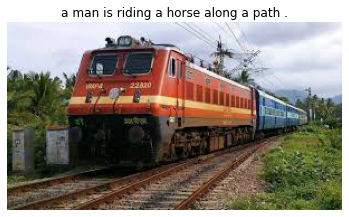

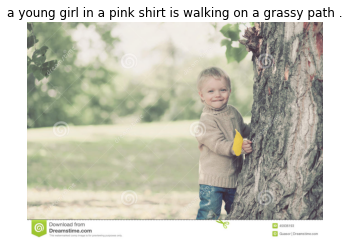

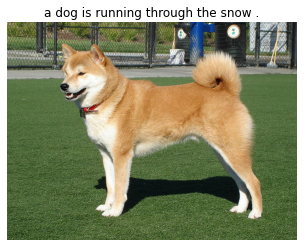

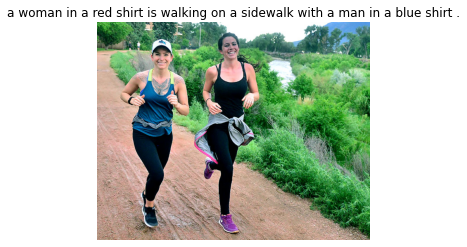

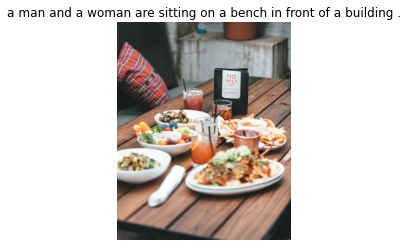

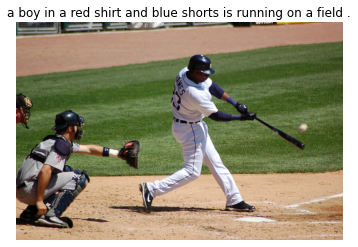

In [13]:
caption_all_images(os.listdir('../input/imageforcaptioning'))

In [1]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='image_captioning_new')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/gitrohitjain/image_captioning_new


<IPython.core.display.Javascript object>